### Setup 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-10-26 14:27:15.202372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load datasets 

train = pd.read_csv('google_trends_combined_gpt_train.csv')
test =  pd.read_csv('google_trends_combined_gpt_test.csv')
subset_of_train = train[['date','laptop','desktop', 'keyboard']]

In [3]:
############## Define variables for training ###############
time_step = 10 # Define time step (number of previous observations)

df_train = subset_of_train # Dataset to use for training 


############# Define variables for prediction ################ 
df_pred = train # dataset to use for keyword selection and prediciton 

keyword_to_predict = 'SSD'

### Data Prep

In [4]:
# Function to create sequences for one keyword trend
def create_sequences_for_keyword(data_column, time_step):
    X, y = [], []
    for i in range(len(data_column) - time_step):
        X.append(data_column[i:i + time_step])  # Sequence of past 'time_step' values
        y.append(data_column[i + time_step])    # The next value to predict
    return np.array(X), np.array(y)


### Modeling

In [5]:
# Define the RNN model only once, before the loop
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(time_step, 1)))  # Input shape is (timesteps, features)
model.add(Dense(1))  # Output layer to predict the next value for the trend

# Compile the model once
model.compile(optimizer='adam', loss='mean_squared_error')

# Iterate over each keyword column, excluding 'date'
for keyword in df_train.columns[1:]:  # Skip the 'date' column
    print(f"Training RNN model for keyword: {keyword}")
    
    # Extract the single keyword's trend data
    single_keyword_data = df_train[keyword].values  # Extract the column data as an array
    
    # Create sequences for the single keyword
    X, y = create_sequences_for_keyword(single_keyword_data, time_step)
    
    # Reshape X to match RNN input format (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 1 feature per keyword
    
    # Split into train and dev sets
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Continue training the model on this keyword's data 
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_dev, y_dev), verbose=1)


# Optionally, save the final trained model after all keywords are trained
#model.save('final_keyword_trend_model.h5')

Training RNN model for keyword: laptop
Epoch 1/50


/Users/Jenny/MADS/Capstone/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2945.3328 - val_loss: 1040.7327
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 773.4222 - val_loss: 92.4102
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164.6131 - val_loss: 28.7135
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59.0858 - val_loss: 24.2173
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52.4616 - val_loss: 20.7922
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 47.5031 - val_loss: 20.4721
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.8577 - val_loss: 19.3517
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 44.2221 - val_loss: 19.2148
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.1163 - val_loss: 19.0906
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.5211 - val_loss: 18.9569
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.3663 - val_loss: 19.2116
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

In [6]:
def predict_future(model, keyword_data, time_step, num_predictions):
    # Get the last known data for the keyword
    last_sequence = keyword_data[-time_step:]  # The last time-step sequence from the data
    predictions = []

    for _ in range(num_predictions):
        # Reshape to match the input shape for the RNN
        predicted = model.predict(last_sequence.reshape(1, time_step, 1))
        predictions.append(predicted[0, 0])  # Get the predicted value

        # Update the sequence with the predicted data for the next step
        last_sequence = np.append(last_sequence[1:], predicted)  # Update the last sequence

    return predictions

# Example usage:
keyword_column_index = df_pred.columns.get_loc(keyword_to_predict)  # Get the column index for the keyword
keyword_data = df_pred[keyword_to_predict].values  # Extract the data for the keyword
future_predictions = predict_future(model, keyword_data, time_step, num_predictions=10)

print(f"Future predictions for {keyword_to_predict}: {future_predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Future predictions for SSD: [3.2635581, 3.451384, 3.6384406, 3.812098, 3.976478, 4.148023, 4.3086796, 4.4718194, 4.633491, 4.7971725]


### Simple Viz

In [7]:
# copy to new df and ensure 'date' is in datetime format
df = df_pred # this is the dataset defined for prediction 
df['date'] = pd.to_datetime(df['date'])

# Generate new dates with a 7-day interval, starting from the last date in df
last_date = df['date'].iloc[-1]
new_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=len(future_predictions), freq='7D')

# Create a new DataFrame for predicted data
predicted_df = pd.DataFrame({'date': new_dates, keyword_to_predict: future_predictions})


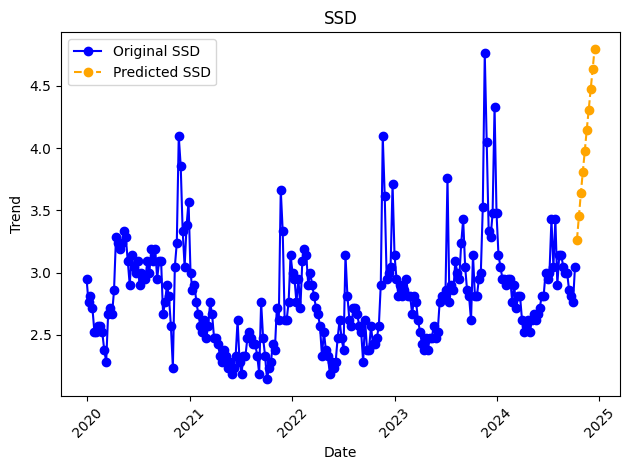

In [8]:
# Plot original data
plt.plot(df['date'], df[keyword_to_predict], marker='o', linestyle='-', color='blue', label='Original SSD')

# Plot predicted data
plt.plot(predicted_df['date'], predicted_df[keyword_to_predict], marker='o', linestyle='--', color='orange', label='Predicted SSD')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title(keyword_to_predict)
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend to differentiate the two lines
plt.legend()

# Show plot
plt.show()

### Saving the model 

In [13]:
import pickle

# Save the model as a pickle file
with open('models/rnn_model_limited_data_v1.pkl', 'wb') as file:
    pickle.dump(model, file)


In [14]:
# Save the model using Keras's save method
model.save('models/rnn_model_limited_data_v1.keras')
